In [1]:
!pip install -q kaggle
!pip install catboost xgboost

from google.colab import files
print('Please, uplouad your kaggle.json file')
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'the-smith-parasite'
! unzip the-smith-parasite.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please, uplouad your kaggle.json file


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
the-smith-parasite.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  the-smith-parasite.zip
replace Sample_Submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Sample_Submission.csv   
  inflating: test_demo.xlsx          
  inflating: test_habits.xlsx        
  inflating: test_health.xlsx        
  inflating: train_demo.xlsx         
  inflating: train_habits.xlsx       
  inflating: train_health.xlsx       


# Libraries imports

In [2]:
import pandas as pd
import numpy as np
from math import ceil
from datetime import date
import os

# ML modeling
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

RS = 42

# Data read
## Train / Test Datasets construction

In [3]:
def make_datasets():
  def get_filenames(suffix=".xlsx" ):
      files = [filename for filename in os.listdir() if filename.endswith(suffix) ]
      return files

  files = get_filenames(suffix=".xlsx" )

  train_frames, test_frames = [],[]
  for file in files:
    if 'train' in file:
      train_frames.append(pd.read_excel(file).set_index('PatientID'))
    elif 'test' in file:
      test_frames.append(pd.read_excel(file).set_index('PatientID'))

  train_df = pd.concat(train_frames, axis = 1)
  test_df = pd.concat(test_frames, axis = 1)
  return train_df, test_df

In [4]:
train_df, test_df = make_datasets()
print(f'Train data size: {train_df.shape[0]} x {train_df.shape[1]}')
print(f'Test data size: {test_df.shape[0]} x {test_df.shape[1]}')

pid = list(test_df.index)
data = pd.concat([train_df, test_df]).reset_index()
data.head()

Train data size: 800 x 18
Test data size: 225 x 17


,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Name,Birth_Year,Region,Education,Disease
0,1167,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1.0
1,1805,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1.0
2,1557,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1.0
3,1658,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,Mr. David Caffee,1958,London,University Complete (3 or more years),0.0
4,1544,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1.0


# Data observation

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         1025 non-null   int64  
 1   Height            1025 non-null   int64  
 2   Weight            1025 non-null   int64  
 3   High_Cholesterol  1025 non-null   int64  
 4   Blood_Pressure    1025 non-null   int64  
 5   Mental_Health     1025 non-null   int64  
 6   Physical_Health   1025 non-null   int64  
 7   Checkup           1025 non-null   object 
 8   Diabetes          1025 non-null   object 
 9   Smoking_Habit     1025 non-null   object 
 10  Drinking_Habit    1025 non-null   object 
 11  Exercise          1025 non-null   object 
 12  Fruit_Habit       1025 non-null   object 
 13  Water_Habit       1025 non-null   object 
 14  Name              1025 non-null   object 
 15  Birth_Year        1025 non-null   int64  
 16  Region            1025 non-null   object 


In [6]:
# Get numbers of unique observations
for col in data.columns:
  print(f'{col}: {data[col].nunique()} unique values')

PatientID: 1025 unique values
Height: 15 unique values
Weight: 58 unique values
High_Cholesterol: 152 unique values
Blood_Pressure: 49 unique values
Mental_Health: 28 unique values
Physical_Health: 24 unique values
Checkup: 4 unique values
Diabetes: 4 unique values
Smoking_Habit: 2 unique values
Drinking_Habit: 3 unique values
Exercise: 2 unique values
Fruit_Habit: 5 unique values
Water_Habit: 3 unique values
Name: 1023 unique values
Birth_Year: 50 unique values
Region: 10 unique values
Education: 6 unique values
Disease: 2 unique values


In [7]:
data.describe()

,PatientID,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Birth_Year,Disease
count,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000
mean,1512.000000,167.721951,67.821463,250.00000,131.611707,17.389268,4.738537,1966.395122,0.513750
std,296.036315,7.982877,12.251687,51.59251,17.516718,5.281313,5.596449,14.335373,0.500124
min,1000.000000,151.000000,40.000000,130.00000,94.000000,0.000000,0.000000,1855.000000,0.000000
25%,1256.000000,162.000000,58.000000,215.00000,120.000000,13.000000,0.000000,1961.000000,0.000000
50%,1512.000000,167.000000,68.000000,244.00000,130.000000,18.000000,3.000000,1966.000000,1.000000
75%,1768.000000,173.000000,77.000000,279.00000,140.000000,21.000000,8.000000,1974.000000,1.000000
max,2024.000000,180.000000,97.000000,568.00000,200.000000,29.000000,30.000000,1993.000000,1.000000


In [8]:
## Number of unique values
# uvals = []
# for col in train_df.columns:
#   uvals.append(train_df[col].nunique())
# stats_df = pd.DataFrame(data = {'Column' : train_df.columns, 'Unique Values' : uvals})
# stats_df = pd.concat([uv_df.set_index('Column'), train_df.isna().sum()], axis = 1)
# stats_df.columns = ['Unique Values', 'NaN values']
# stats_df

In [9]:
numeric_cols = data.dtypes[data.dtypes != 'object'].index
numeric_cols

Index(['PatientID', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Birth_Year', 'Disease'],
      dtype='object')

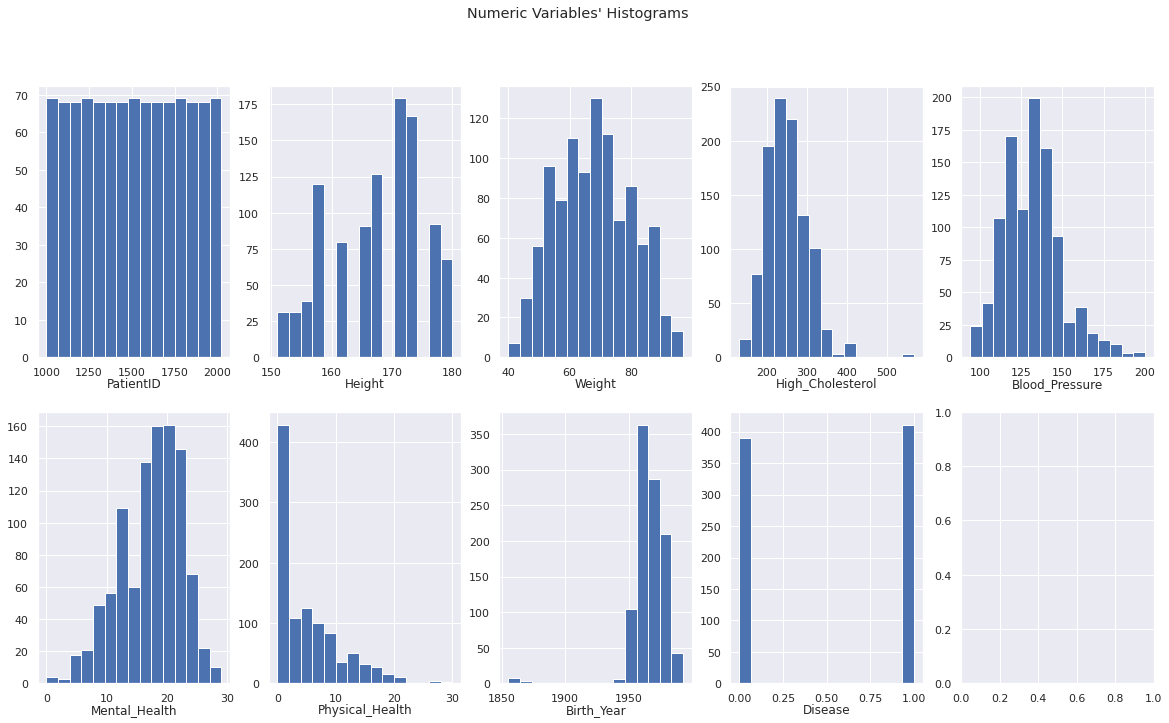

In [10]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"
plt.suptitle(title)

plt.show()

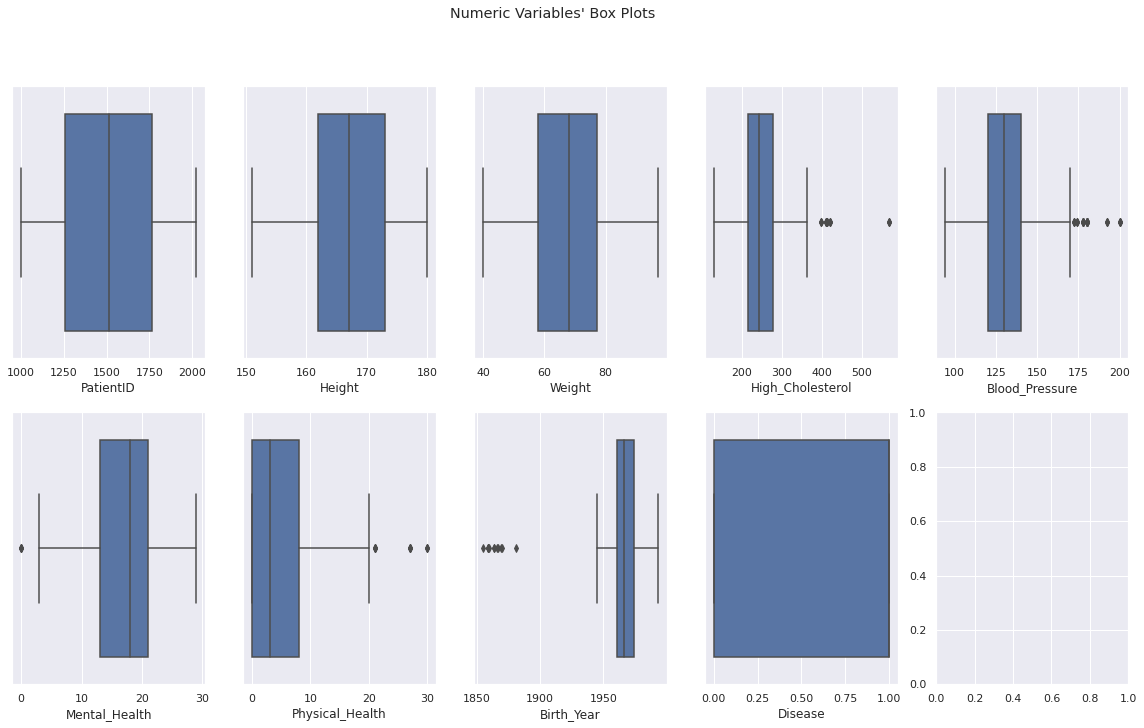

In [11]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols): 
    sns.boxplot(x=data[feat], ax=ax)
    
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()

# Feature Creation

1) Age <br>
2) Sex <br>
3) Ordinal variables <br>
4) Binary variables <br>
5) One Hot Encoding <br>
6) Feture selection

In [12]:
def feature_creation(df):
  ordinal_dicts = {

  'Drinking_Habit' : {'I do not consume any type of alcohol' : [0],
                      'I consider myself a social drinker' : [1],
                      'I usually consume alcohol every day' : [2]},

  'Water_Habit' : {'Between one liter and two liters' : [0],
                  'More than half a liter but less than one liter' : [1],
                  'Less than half a liter' : [2]},
                  
  'Fruit_Habit' : {'More than six pieces of fruit' : [0],
                  '5 to 6 pieces of fruit in average' : [1],
                  '3 to 4 pieces of fruit in average' : [2],
                  '1 to 2 pieces of fruit in average' : [3],
                  'Less than 1. I do not consume fruits every day.' : [4]},
                  
  'Diabetes' : {'Neither I nor my immediate family have diabetes.' : [0],
                "I don't have diabetes, but I have direct family members who have diabetes." : [1],
                'I have/had pregnancy diabetes or borderline diabetes' : [2],
                'I do have diabetes' : [3]},

  'Checkup' :  { 'Less than three months': [0],
                'Less than 3 years but more than 1 year' : [1],
                'More than 3 years' : [2],
                'Not sure': [3]}
                }
  # 1
  df['sex'] = df['Name'].str.contains('Mrs. ').astype(int)
  # 2
  df['age'] = date.today().year - df['Birth_Year']
  # 3
  drop_list = ['PatientID', 'Name', 'Birth_Year', 'Region', 'Education']
  for key in ordinal_dicts.keys():                  
    drinking_habit_map = pd.DataFrame(data = ordinal_dicts[key]).T.reset_index()
    drinking_habit_map.columns = [key, f'{key}_ord']
    df = df.merge(drinking_habit_map, how = 'left', on = [key])
    drop_list.append(key)
  # 4
  df.replace({"Exercise": {'Yes' : 0, 'No' : 1}}, inplace = True)
  df.replace({"Smoking_Habit": {'Yes' : 1, 'No' : 0}}, inplace = True)
  # 5
  one_hot = pd.get_dummies(df['Region'].str.lower(), prefix = '_geo_')
  one_hot_2 = pd.get_dummies(data['Education'].str.lower(), prefix = '_edu_')
  df = pd.concat([df, one_hot, one_hot_2], axis = 1)
  df = pd.concat([df, one_hot], axis = 1)
  df.drop(columns = drop_list, inplace = True)

  return df

data = feature_creation(data)
data.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,...,_edu__university incomplete (1 to 2 years),_geo__east midlands,_geo__east of england,_geo__london,_geo__north east,_geo__north west,_geo__south east,_geo__south west,_geo__west midlands,_geo__yorkshire and the humber
0,155,67,358,120,21,2,0,0,1.0,1,...,0,0,0,1,0,0,0,0,0,0
1,173,88,230,142,9,0,0,0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
2,162,68,226,122,26,0,0,1,1.0,0,...,0,0,0,0,0,0,0,0,0,1
3,180,66,313,125,13,8,0,0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
4,180,58,277,125,18,2,0,1,1.0,0,...,1,0,0,0,0,0,1,0,0,0


### 6) Feature selection (Random Forest)

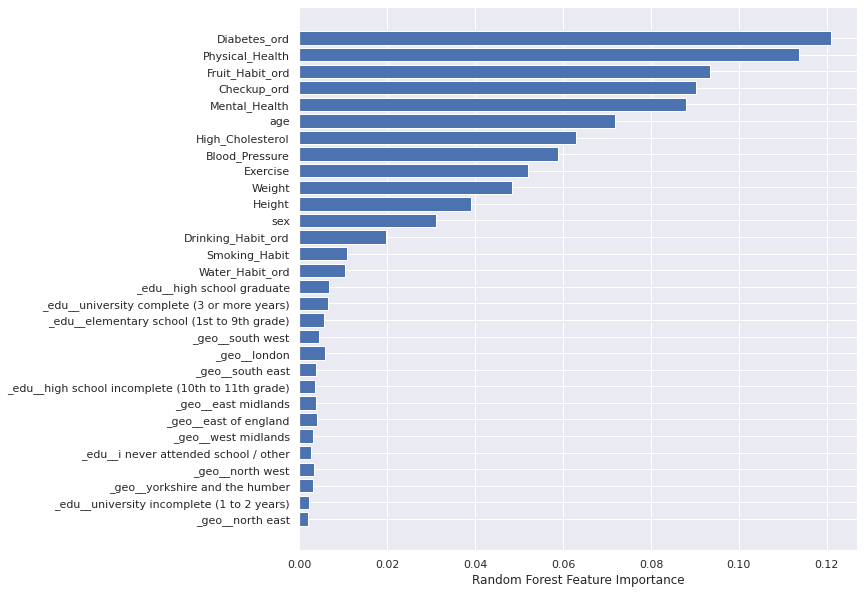

In [13]:
def rf_fi(data):
  train_part = data[data['Disease'].notnull()]
  X = train_part.drop(columns = ['Disease'])
  y = train_part[['Disease']]

  # Creation of default Random Forest Classifier to get feature importance
  clf = RandomForestClassifier() 
  clf.fit(X, y)

  sorted_idx = clf.feature_importances_.argsort()
  plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
  plt.xlabel("Random Forest Feature Importance")

plt.rcParams['figure.figsize'] = [10, 10]
rf_fi(data)

> ⚠ We see that variables describing education and region bring too litle impact into the classification model. So it was decided not to use them.

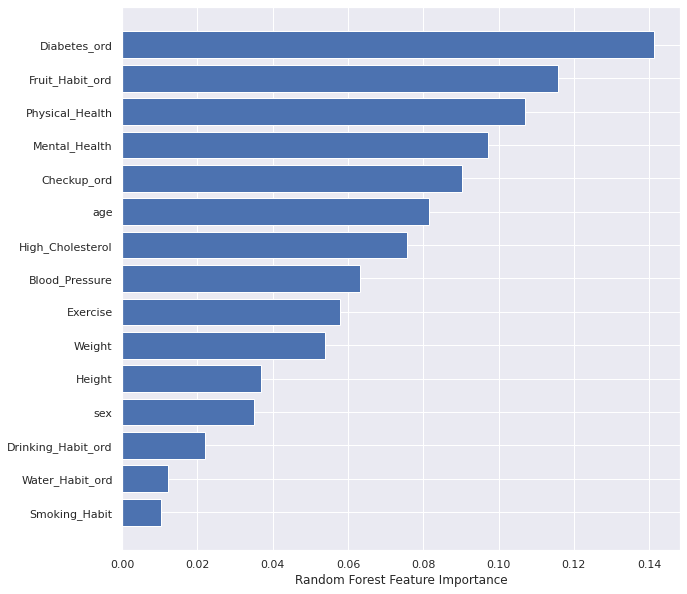

In [14]:
drop_list = []
for col in data.columns:
  if ('_geo_' in col) or ('_edu_'in col):
    drop_list.append(col)

data.drop(columns = drop_list, inplace = True)
rf_fi(data)

# Preprocessing with statistical information

1) Outliers removal<br>
2) Correlations check<br>


### 1) Outliers detection

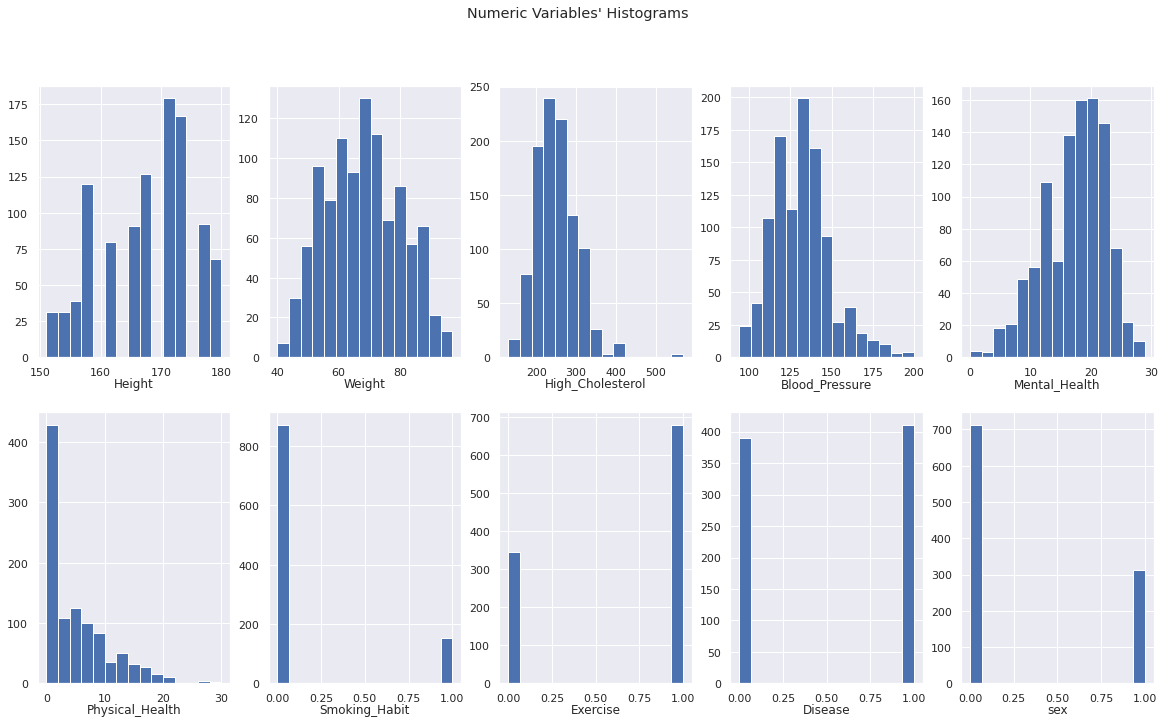

In [15]:
numeric_cols = data.dtypes[data.dtypes != 'object'].index

sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols[:-6]) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols[:-6]):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"
plt.suptitle(title)

plt.show()

In [16]:
data.describe()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,167.721951,67.821463,250.00000,131.611707,17.389268,4.738537,0.149268,0.663415,0.513750,0.304390,55.604878,1.485854,0.640976,3.245854,1.118049,2.323902
std,7.982877,12.251687,51.59251,17.516718,5.281313,5.596449,0.356527,0.472772,0.500124,0.460373,14.335373,0.528527,0.664295,1.030798,1.183676,0.620660
min,151.000000,40.000000,130.00000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,58.000000,215.00000,120.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,1.000000,0.000000,3.000000,0.000000,2.000000
50%,167.000000,68.000000,244.00000,130.000000,18.000000,3.000000,0.000000,1.000000,1.000000,0.000000,56.000000,2.000000,1.000000,4.000000,1.000000,2.000000
75%,173.000000,77.000000,279.00000,140.000000,21.000000,8.000000,0.000000,1.000000,1.000000,1.000000,61.000000,2.000000,1.000000,4.000000,2.000000,3.000000
max,180.000000,97.000000,568.00000,200.000000,29.000000,30.000000,1.000000,1.000000,1.000000,1.000000,167.000000,2.000000,2.000000,4.000000,3.000000,3.000000


In [17]:
def outliers_remove(df, column):
  Q1 = df[column].quantile(.25)
  Q3 = df[column].quantile(.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  rep_func = lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
  df[column] = df[column].apply(rep_func)
  return df

for col in ['age', 'High_Cholesterol', 'Height', 'Weight', 'Blood_Pressure']:
  data = outliers_remove(data, col)
data.head()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
0,155,67,358.0,120.0,21,2,0,0,1.0,1,57.0,2,0,4,0,2
1,173,88,230.0,142.0,9,0,0,0,1.0,0,53.0,1,0,4,0,3
2,162,68,226.0,122.0,26,0,0,1,1.0,0,48.0,1,1,4,0,2
3,180,66,313.0,125.0,13,8,0,0,0.0,0,64.0,2,1,4,2,3
4,180,58,277.0,125.0,18,2,0,1,1.0,0,54.0,1,1,3,2,2


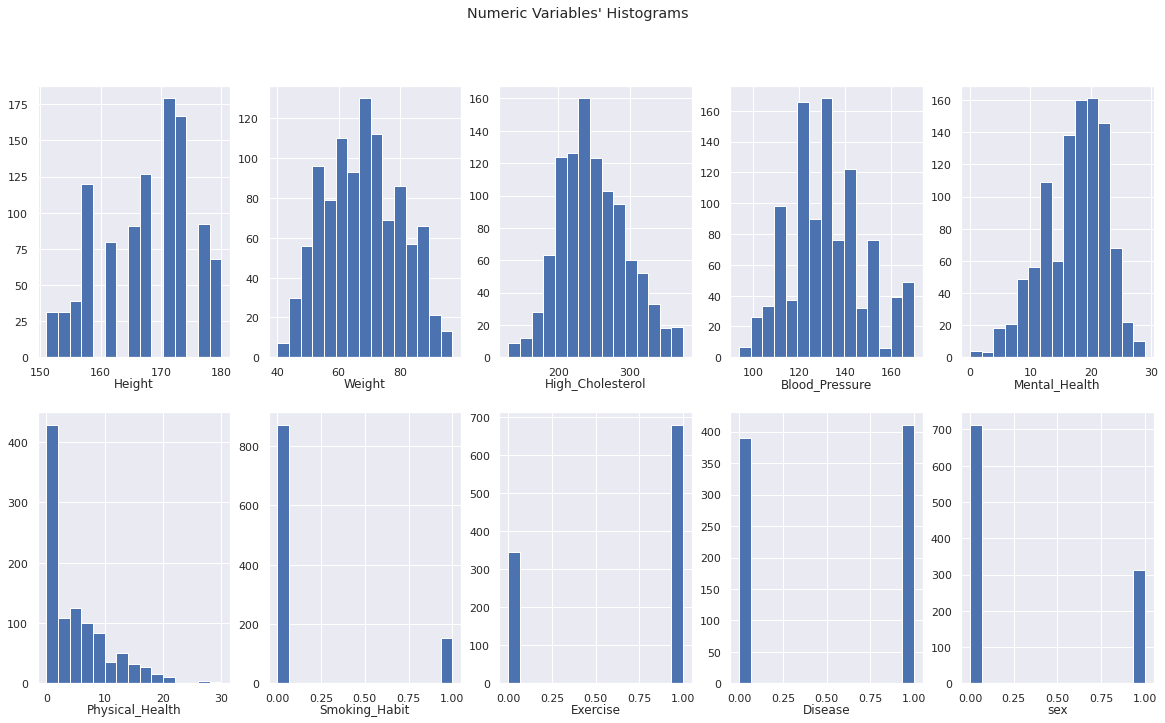

In [18]:
sns.set()
fig, axes = plt.subplots(2, ceil(len(numeric_cols[:-6]) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), numeric_cols[:-6]):
    ax.hist(data[feat], bins = 15)
    ax.set_title(feat, y=-0.13)
  
title = "Numeric Variables' Histograms"
plt.suptitle(title)
plt.show()

We can see that the most of distributions have taken a more recognizable bell-shaped form of a normal distribution. <br>

Outliers have vanished. <br>

To see new min-max values we call **.describe()** function again:

In [19]:
data.describe()

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Smoking_Habit,Exercise,Disease,sex,age,Drinking_Habit_ord,Water_Habit_ord,Fruit_Habit_ord,Diabetes_ord,Checkup_ord
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,800.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,167.721951,67.821463,248.981463,131.260488,17.389268,4.738537,0.149268,0.663415,0.513750,0.304390,54.702439,1.485854,0.640976,3.245854,1.118049,2.323902
std,7.982877,12.251687,47.746162,16.532208,5.281313,5.596449,0.356527,0.472772,0.500124,0.460373,9.463604,0.528527,0.664295,1.030798,1.183676,0.620660
min,151.000000,40.000000,130.000000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,58.000000,215.000000,120.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,1.000000,0.000000,3.000000,0.000000,2.000000
50%,167.000000,68.000000,244.000000,130.000000,18.000000,3.000000,0.000000,1.000000,1.000000,0.000000,56.000000,2.000000,1.000000,4.000000,1.000000,2.000000
75%,173.000000,77.000000,279.000000,140.000000,21.000000,8.000000,0.000000,1.000000,1.000000,1.000000,61.000000,2.000000,1.000000,4.000000,2.000000,3.000000
max,180.000000,97.000000,375.000000,170.000000,29.000000,30.000000,1.000000,1.000000,1.000000,1.000000,80.500000,2.000000,2.000000,4.000000,3.000000,3.000000


### 2) Correlation check

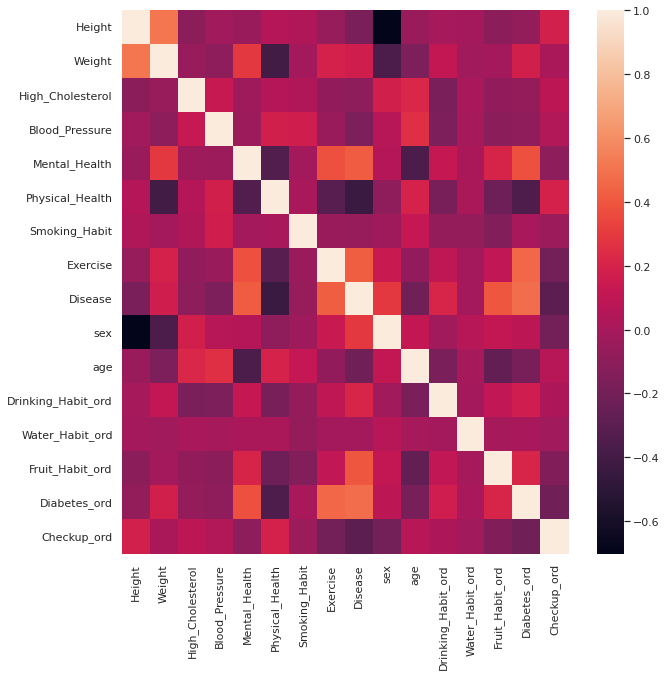

In [20]:
sns.heatmap(data.corr());

There are no highly correlated variables except "Sex" and "Height". But we may leave them as the absolute value is only ~0.6 and "Sex" is a binary variable

# Train / Val / Test split

In [21]:
test_df = data[data['Disease'].isnull()].drop(columns = ['Disease'])
train_df = data[data['Disease'].notnull()]

y = train_df['Disease']
X = train_df.drop(columns = ['Disease'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    shuffle = True, 
                                                    random_state = RS)

# Scaled copy of the data (for some models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

> ⚠ Actually we did not use the **train/val/test** devision due to usage of K-Folds CV. It will help us to obtain metrics more accuratly and will help us to avoid possible overfitting.

# ML models
1) Logistic Regression<br>
2) SVM<br>
3) Decision Tree<br>
4) MLPClassifier<br>
5) Random Forest<br>
6) Gradient Boosting
7) CatBoost (not sklearn)<br>
8) XGBoost (not sklearn)<br>
9) AdaBoost<br>
10) Stacking Classifier<br>


In [22]:
plt.rcParams['figure.figsize'] = [8, 6]
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = RS)

def peformance_check(model, train_data):
  avg_f1 = np.mean(cross_val_score(model, train_data, y, scoring = 'f1', cv = cv))
  avg_acc = np.mean(cross_val_score(model, train_data, y, scoring = 'accuracy', cv = cv))
  avg_recall = np.mean(cross_val_score(model, train_data, y, scoring = 'recall', cv = cv))
  avg_prec = np.mean(cross_val_score(model, train_data, y, scoring = 'precision', cv = cv))
  return {'f1' : avg_f1, 'Accuracy' : avg_acc, 'Recall' : avg_recall, 'Precision' : avg_prec}

def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

def return_results(models, X, y, plot = False, par = 'Parameter'):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    if plot:
      plt.figure(figsize=(10,6))
      plt.boxplot(results, labels = names, showmeans = True)
      plt.xticks(fontsize=10)
      plt.title("F1 evaluation")
      plt.xlabel(f'{par} value') 
      plt.ylabel('F1 distribution') 
      plt.show()

def get_models(values, template):
    models = dict()
    for value in values:
        models[str(value)] = eval(template)      
    return models

### 1. Logistic Regression

In [23]:
models = get_models(['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], template = "LogisticRegression(solver = value)")
return_results(models, X_train_scaled, y_train, plot = False)

>liblinear 0.839 (0.049)
>lbfgs 0.839 (0.049)
>newton-cg 0.839 (0.049)
>sag 0.839 (0.049)
>saga 0.839 (0.049)


In [24]:
parameters = {"penalty":["l1","l2"], "solver" : ['lbfgs']}
lreg = LogisticRegression()
logreg_cv = GridSearchCV(lreg, parameters, cv=cv)
logreg_cv.fit(X, y)
lr_bp = logreg_cv.best_params_
print('Best parameters:', lr_bp)

print('\nAverage Metrics using K-Folds CV:')
peformance_check(LogisticRegression(**lr_bp), X)

Best parameters: {'penalty': 'l2', 'solver': 'lbfgs'}

Average Metrics using K-Folds CV:


{'f1': 0.8337065017391182,
 'Accuracy': 0.8262499999999998,
 'Recall': 0.8475222609368952,
 'Precision': 0.8238771082868575}

### 2. SVM

F1 evaluation (on "C" Regularisation)
>3 0.928 (0.027)
>4 0.936 (0.029)
>5 0.940 (0.030)
>6 0.948 (0.027)
>7 0.950 (0.025)
>8 0.955 (0.023)
>9 0.957 (0.021)
>10 0.961 (0.020)
>11 0.963 (0.020)
>12 0.962 (0.020)
>13 0.963 (0.019)
>14 0.963 (0.019)


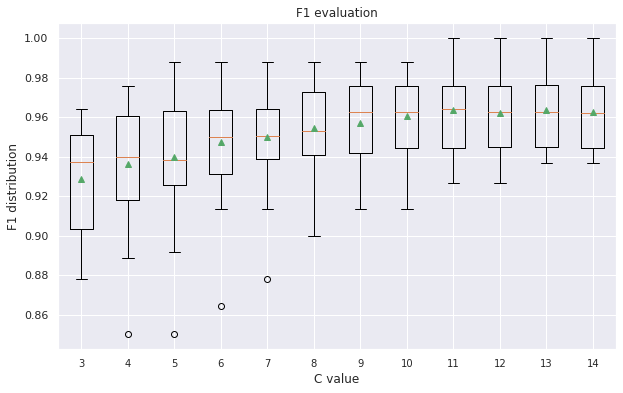

In [25]:
print('F1 evaluation (on "C" Regularisation)')
models = get_models(range(3, 15), template = "SVC(C = value)")
return_results(models, X_scaled, y, plot = True, par = 'C')

In [26]:
print('F1 evaluation (on "kernel")')
models = get_models(['linear', 'poly', 'rbf', 'sigmoid'], template = "SVC(kernel = value)")
return_results(models, X_train_scaled, y_train)

F1 evaluation (on "kernel")
>linear 0.831 (0.047)
>poly 0.900 (0.035)
>rbf 0.887 (0.041)
>sigmoid 0.806 (0.047)


In [27]:
# GridSearch
print('GridSearch of hyperparameters')
parameters = {"C":[10, 11, 12], 
              "kernel" : ['poly', 'rbf'],
              "random_state" : [RS]}
svm_cv = GridSearchCV(SVC(), parameters, cv=cv)
svm_cv.fit(X_train_scaled, y_train)

svm_bp = svm_cv.best_params_
print('Best parameters optained:', svm_bp)

print('\nAverage Metrics using K-Folds CV:')
peformance_check(SVC(**svm_bp), X_scaled)

GridSearch of hyperparameters
Best parameters optained: {'C': 10, 'kernel': 'rbf', 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.9605868103377131,
 'Accuracy': 0.9595833333333333,
 'Recall': 0.9586140147115756,
 'Precision': 0.9635364731186745}

In [28]:
# Comparison with default model (scaled data)
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(SVC(random_state = RS), X_scaled)


Average Metrics using K-Folds CV (default model):


{'f1': 0.7346082577822982,
 'Accuracy': 0.7095833333333335,
 'Recall': 0.7835462640340689,
 'Precision': 0.6936001495560483}

In [ ]:
# Comparison with default model (unscaled data)
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(SVC(random_state = RS), X)

### 3. Decision Tree

F1 evaluation (on "max_depth")
>4 0.843 (0.038)
>5 0.869 (0.040)
>6 0.913 (0.040)
>7 0.932 (0.034)
>8 0.953 (0.030)
>9 0.958 (0.026)
>10 0.960 (0.025)
>11 0.960 (0.025)
>12 0.962 (0.025)
>13 0.962 (0.025)
>14 0.962 (0.025)


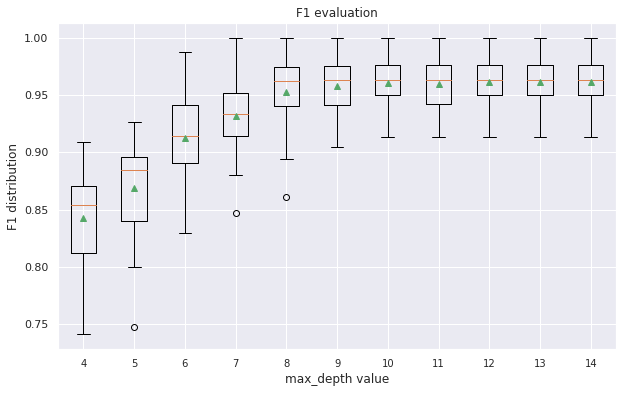

In [29]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 15, 1), template = "DecisionTreeClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [30]:
# GridSearch
print('GridSearch of hyperparameters')
parameters = {"max_depth":[9, 10, 11, 12], 
              "criterion" : ['gini', 'entropy'],
              "random_state" : [RS]}

dtc_cv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=cv)
dtc_cv.fit(X, y)
dtc_bp = dtc_cv.best_params_

print('Best parameters:', dtc_bp)
print('\nAverage Metrics using K-Folds CV:')
peformance_check(DecisionTreeClassifier(**dtc_bp), X)

GridSearch of hyperparameters
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.9704716465221013,
 'Accuracy': 0.9700000000000001,
 'Recall': 0.9610917537746805,
 'Precision': 0.9809618224153108}

In [31]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(DecisionTreeClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9615022810684548,
 'Accuracy': 0.9608333333333334,
 'Recall': 0.952168021680217,
 'Precision': 0.971936428100637}

### 4. MLPClassifier

In [32]:
print('F1 evaluations:')
print('\n > Check for best "hidden_layer_sizes"')
models = get_models([70, 80, 90, 100,], template = "MLPClassifier(hidden_layer_sizes = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "activation" function')
models = get_models(['logistic', 'tanh', 'relu'], template = "MLPClassifier(activation = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "learning_rate_init"')
models = get_models([5e-3, 1e-3, 5e-4], template = "MLPClassifier(activation = 'tanh', learning_rate_init = value, random_state = RS)")
return_results(models, X, y, plot = False)

F1 evaluations:

 > Check for best "hidden_layer_sizes"
>70 0.830 (0.039)
>80 0.816 (0.047)
>90 0.814 (0.061)
>logistic 0.849 (0.040)
>tanh 0.866 (0.040)
>relu 0.816 (0.048)

 > Check for best "learning_rate_init"
>0.005 0.831 (0.041)
>0.001 0.866 (0.040)
>0.0005 0.851 (0.037)


In [33]:
# GridSearch
print('GridSearch of MLPClassifier hyperparameters')
parameters = {"hidden_layer_sizes":[78, 80, 82], 
              "activation" : ['logistic', 'tanh'],
              "learning_rate_init" : [1e-3],
              "random_state" : [RS]}
mlp_cv = GridSearchCV(MLPClassifier(), parameters, cv=cv)
mlp_cv.fit(X, y)
mlp_bp = mlp_cv.best_params_

print('Best parameters:', mlp_bp)
print('\nAverage Metrics using K-Folds CV:')
peformance_check(MLPClassifier(**mlp_bp), X)

GridSearch of MLPClassifier hyperparameters
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': 78, 'learning_rate_init': 0.001, 'random_state': 42}

Average Metrics using K-Folds CV:


{'f1': 0.8557330450849273,
 'Accuracy': 0.8487500000000002,
 'Recall': 0.871873790166473,
 'Precision': 0.8432743078875706}

In [34]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(MLPClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.816396212867879,
 'Accuracy': 0.8120833333333335,
 'Recall': 0.828281068524971,
 'Precision': 0.8230188770782438}

### 5. Random Forest

F1 evaluation (on "n_estimators")
>50 0.980 (0.014)
>60 0.980 (0.016)
>70 0.981 (0.017)
>80 0.980 (0.018)
>90 0.979 (0.017)
>100 0.979 (0.017)


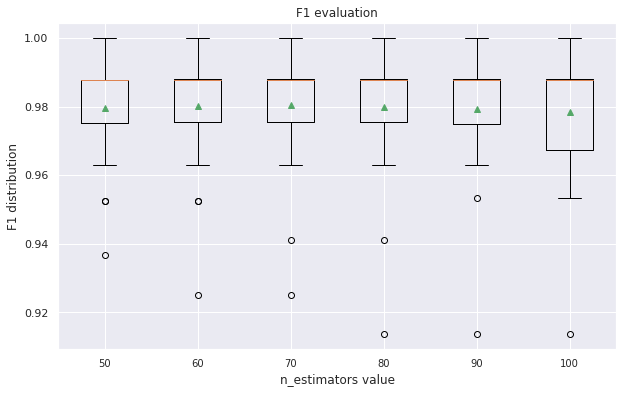

In [35]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(50, 110, 10), template = "RandomForestClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

F1 evaluation (on "max_depth")
>4 0.884 (0.032)
>5 0.906 (0.026)
>6 0.932 (0.024)
>7 0.955 (0.027)
>8 0.971 (0.023)
>9 0.974 (0.020)
>10 0.975 (0.020)
>11 0.976 (0.017)
>12 0.978 (0.018)
>13 0.978 (0.018)


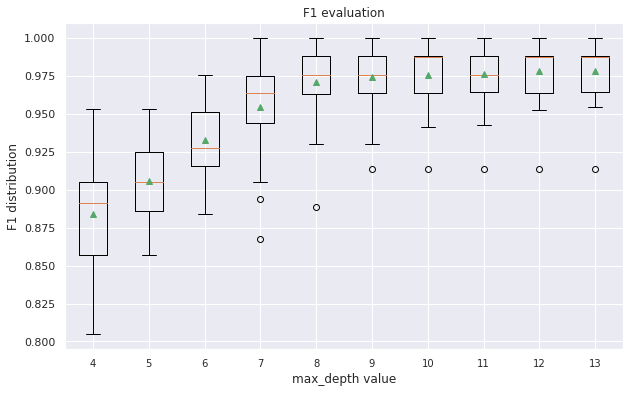

In [36]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 14, 1), template = "RandomForestClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [37]:
print('F1 evaluations')
print('\n > Check for best "min_samples_split"')
models = get_models(range(2, 6, 1), template = "RandomForestClassifier(min_samples_split = value, random_state = RS)")
return_results(models, X, y)

print('\n > Check for best "min_samples_leaf"')
models = get_models(range(2, 6, 1), template = "RandomForestClassifier(min_samples_leaf = value, random_state = RS)")
return_results(models, X, y)

print('\n > Check for best "criterion"')
models = get_models(['gini', 'entropy'], template = "RandomForestClassifier(criterion = value, random_state = RS)")
return_results(models, X, y)

F1 evaluations

 > Check for best "min_samples_split"
>2 0.979 (0.017)
>3 0.979 (0.019)
>4 0.974 (0.023)
>5 0.967 (0.020)

 > Check for best "min_samples_leaf"
>2 0.960 (0.021)
>3 0.946 (0.027)
>4 0.935 (0.027)
>5 0.926 (0.033)

 > Check for best "criterion"
>gini 0.979 (0.017)
>entropy 0.976 (0.017)


In [38]:
# GridSearch
print('GridSearch of RandomForest hyperparameters')
parameters = {"n_estimators":[100, 110, 120], 
              "max_depth" : [9, 10, 11, None],
              "random_state" : [RS]}
              
rfc_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=cv)
rfc_cv.fit(X, y)
rfc_bp = rfc_cv.best_params_

print('Best parameters:', rfc_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(RandomForestClassifier(**rfc_bp), X)

GridSearch of RandomForest hyperparameters
Best parameters: {'max_depth': None, 'n_estimators': 100, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9785307735376099,
 'Accuracy': 0.9779166666666668,
 'Recall': 0.9781262098335269,
 'Precision': 0.9793426015277972}

In [39]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(RandomForestClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9785307735376099,
 'Accuracy': 0.9779166666666668,
 'Recall': 0.9781262098335269,
 'Precision': 0.9793426015277972}

### 6. Gradient Boosting

F1 evaluation (on "learning_rate")
>0.001 0.826 (0.044)
>0.01 0.854 (0.039)
>0.1 0.940 (0.025)
>0.2 0.970 (0.024)
>0.4 0.981 (0.018)
>0.6 0.981 (0.018)
>0.8 0.981 (0.017)
>1.0 0.983 (0.016)
>1.2 0.981 (0.018)


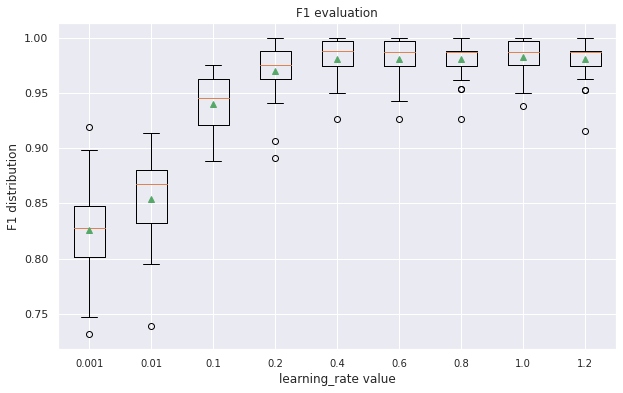

In [40]:
print('F1 evaluation (on "learning_rate")')
models = get_models([0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], 
                    template = "GradientBoostingClassifier(learning_rate = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'learning_rate')

F1 evaluation (on "n_estimators")
>100 0.940 (0.025)
>150 0.962 (0.021)
>200 0.970 (0.019)
>250 0.973 (0.019)
>300 0.977 (0.016)
>350 0.980 (0.015)
>400 0.980 (0.017)
>450 0.981 (0.016)
>500 0.981 (0.017)
>550 0.982 (0.017)
>600 0.981 (0.017)


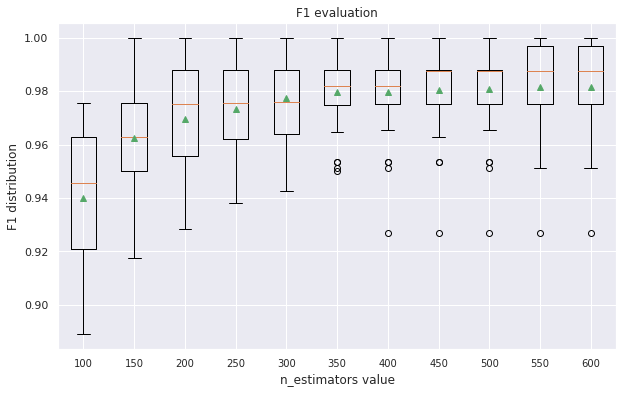

In [41]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(100, 650, 50), 
                    template = "GradientBoostingClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

In [42]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(3, 8), 
                    template = "GradientBoostingClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y)

F1 evaluation (on "max_depth")
>3 0.940 (0.025)
>4 0.983 (0.017)
>5 0.984 (0.018)
>6 0.985 (0.015)
>7 0.978 (0.021)


In [43]:
# GridSearch
print('GridSearch of GradientBoosting hyperparameters')
parameters = {"n_estimators":[500, 550, 600], 
              "max_depth" : [4, 5, 6, None],
              "learning_rate" : [0.1, 0.2],
              "random_state" : [RS]}
              
gb_cv = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10)
gb_cv.fit(X, y)
gb_bp = gb_cv.best_params_
print('Best parameters:', gb_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(GradientBoostingClassifier(**gb_bp), X)

GridSearch of GradientBoosting hyperparameters
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9871208818958959,
 'Accuracy': 0.9866666666666667,
 'Recall': 0.9902632597754548,
 'Precision': 0.9844403560767712}

In [44]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(GradientBoostingClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9401777161761511,
 'Accuracy': 0.9383333333333332,
 'Recall': 0.9408246225319398,
 'Precision': 0.9404971972645944}

Comparing with a default GradientBoostingClassifier model we have obtained much better hyperparameters which show us **F1= 0.987** against 0.940 with use of K-Folds CV.

### 7. CatBoost

**CatBoost** is an open-source software library developed by **Yandex**. It provides a gradient boosting framework which among other features attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm

F1 evaluation (on "learning_rate")
>0.001 0.906 (0.029)
>0.01 0.983 (0.019)
>0.1 0.989 (0.014)
>0.3 0.990 (0.012)
>0.5 0.989 (0.014)
>0.8 0.984 (0.017)
>1.0 0.984 (0.015)


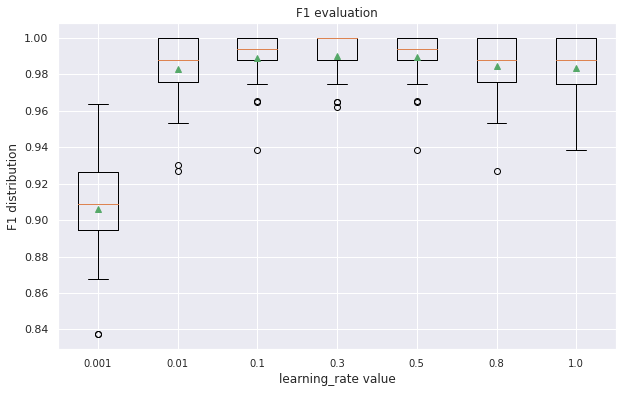

In [45]:
print('F1 evaluation (on "learning_rate")')
models = get_models([0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1.0], 
                    template = "CatBoostClassifier(learning_rate = value, silent = True, random_state = RS)")
return_results(models, X, y, plot = True, par = 'learning_rate')

F1 evaluation (on "iterations")
>100 0.927 (0.032)
>150 0.929 (0.029)
>200 0.976 (0.025)
>250 0.979 (0.021)
>300 0.977 (0.026)
>350 0.978 (0.021)
>400 0.979 (0.022)
>450 0.979 (0.023)


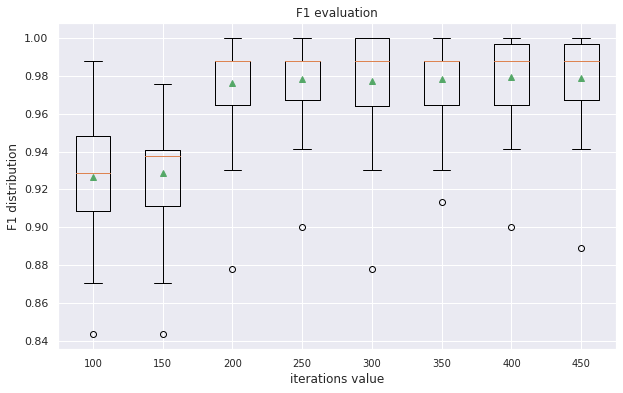

In [46]:
print('F1 evaluation (on "iterations")')
models = get_models(range(100, 500, 50), 
                    template = "CatBoostClassifier(iterations = value, silent = True, random_state = RS)")
return_results(models, X, y, plot = True, par = 'iterations')

In [47]:
print('F1 evaluation (on "depth")')
models = get_models(range(4, 11, 1), 
                    template = "CatBoostClassifier(depth = value, silent = True, random_state = RS)")
return_results(models, X, y)

F1 evaluation (on "depth")
>4 0.950 (0.030)
>5 0.970 (0.026)
>6 0.982 (0.021)
>7 0.988 (0.016)
>8 0.989 (0.015)
>9 0.989 (0.014)
>10 0.990 (0.014)


In [48]:
# GridSearch
print('GridSearch of CatBoost hyperparameters')
parameters = {"iterations":[250, 350, 400], 
              "depth" : [7, 8, None],
              "learning_rate" : [0.2, 0.3, 0.4],
              "random_state" : [RS],
              "silent" : [True]}
              
cat_cv = GridSearchCV(CatBoostClassifier(), parameters, cv=10)
cat_cv.fit(X, y)
cat_bp = cat_cv.best_params_
print('Best parameters:', cat_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(CatBoostClassifier(**cat_bp), X)

GridSearch of CatBoost hyperparameters
Best parameters: {'depth': 8, 'iterations': 250, 'learning_rate': 0.2, 'random_state': 42, 'silent': True}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9894657275538566,
 'Accuracy': 0.9891666666666666,
 'Recall': 0.9894502516453735,
 'Precision': 0.9897448351106888}

In [49]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(CatBoostClassifier(silent = True, random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.9819105225578109,
 'Accuracy': 0.98125,
 'Recall': 0.9846109175377469,
 'Precision': 0.9795516136979552}

Comparing obtained model with a default CatBoost classification we have found much better hyperparameters which lead us **F1= 0.989** against 0.981 with use of K-Folds CV.

### XGBoost
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (GBDT, GBM) that solve many data science problems in a fast and accurate way.

https://xgboost.readthedocs.io/en/stable/python/python_api.html

F1 evaluation (on "n_estimators")
>300 0.977 (0.017)
>350 0.982 (0.014)
>400 0.983 (0.014)
>450 0.985 (0.013)
>500 0.985 (0.014)
>550 0.985 (0.013)
>600 0.986 (0.013)
>650 0.986 (0.013)


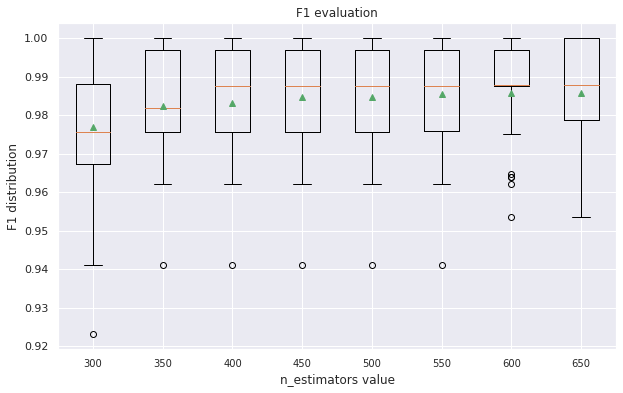

In [50]:
print('F1 evaluation (on "n_estimators")')
models = get_models(range(300, 700, 50), template = "XGBClassifier(n_estimators = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'n_estimators')

F1 evaluation (on "max_depth")
>4 0.971 (0.021)
>6 0.984 (0.018)
>8 0.981 (0.019)
>10 0.982 (0.018)
>12 0.982 (0.018)


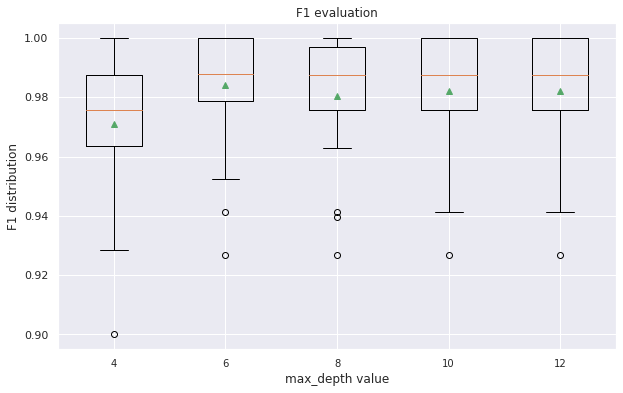

In [51]:
print('F1 evaluation (on "max_depth")')
models = get_models(range(4, 14, 2), template = "XGBClassifier(max_depth = value, random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth')

In [52]:
print('Other F1 evaluations')
print('\n > Check for best "learning_rate"')
models = get_models([1, 5e-1, 1e-1, 1e-2, 5e-3], template = "XGBClassifier(learning_rate = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "reg_alpha" (Lasso L1 Regularization)')
models = get_models([1, 1e-1, 1e-2, 5e-3, 1e-3, 0], template = "XGBClassifier(reg_alpha = value, random_state = RS)")
return_results(models, X, y, plot = False)

print('\n > Check for best "reg_lambda" (Ridge L2 Regularization)')
models = get_models([1, 1e-1, 1e-2, 5e-3, 1e-3, 0], template = "XGBClassifier(reg_lambda = value, random_state = RS)")
return_results(models, X, y, plot = False)

Other F1 evaluations

 > Check for best "learning_rate"
>1 0.981 (0.017)
>0.5 0.983 (0.016)
>0.1 0.935 (0.026)
>0.01 0.855 (0.045)
>0.005 0.833 (0.043)

 > Check for best "reg_alpha" (Lasso L1 Regularization)
>1 0.920 (0.025)
>0.1 0.932 (0.027)
>0.01 0.931 (0.029)
>0.005 0.933 (0.027)
>0.001 0.935 (0.027)
>0 0.935 (0.026)

 > Check for best "reg_lambda" (Ridge L2 Regularization)
>1 0.935 (0.026)
>0.1 0.940 (0.027)
>0.01 0.943 (0.026)
>0.005 0.942 (0.023)
>0.001 0.944 (0.026)
>0 0.943 (0.027)


In [53]:
parameters = {"n_estimators":[550, 600, 650], 
              "max_depth" : [5, 6, 7, None],
              "learning_rate" : [0.5, 0.1],
              "random_state" : [RS]}
              
xgb_cv = GridSearchCV(XGBClassifier(), parameters, cv=10)
xgb_cv.fit(X, y)
xgb_bp = xgb_cv.best_params_
print('Best parameters:', xgb_bp)

print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(XGBClassifier(**xgb_bp), X)

Best parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 550, 'random_state': 42}

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.985083319361585,
 'Accuracy': 0.9845833333333334,
 'Recall': 0.9854239256678282,
 'Precision': 0.9851664880989895}

In [54]:
# Comparison with default model
print('\nAverage Metrics using K-Folds CV (default model):')
peformance_check(XGBClassifier(random_state = RS), X)


Average Metrics using K-Folds CV (default model):


{'f1': 0.935420037646879,
 'Accuracy': 0.9333333333333335,
 'Recall': 0.9375725900116142,
 'Precision': 0.934604617452186}

Comparing obtained model with a default XGBoost classification we have found much better hyperparameters which lead us **F1= 0.985** against 0.935 with use of K-Folds CV.

### AdaBoost

In [55]:
print('Best "base_estimator" search')
models = [('rf', AdaBoostClassifier(base_estimator = RandomForestClassifier(), random_state = RS)),
          ('dt', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = RS)),
          ('lr', AdaBoostClassifier(base_estimator = LogisticRegression(), random_state = RS)),]

for model in models:
  print('>', model[0], peformance_check(model[1], X))

Best "base_estimator" search
> rf {'f1': 0.9807418750290107, 'Accuracy': 0.9800000000000002, 'Recall': 0.9830236159504453, 'Precision': 0.9790310248038552}
> dt {'f1': 0.9674097664805503, 'Accuracy': 0.9666666666666668, 'Recall': 0.9627371273712736, 'Precision': 0.9729871289287643}
> lr {'f1': 0.8336476390817145, 'Accuracy': 0.8262499999999999, 'Recall': 0.8466705381339529, 'Precision': 0.8236756694180701}


F1 evaluation (on "max_depth" of base_estimator model)
>4 0.956 (0.027)
>5 0.947 (0.026)
>6 0.959 (0.026)
>7 0.965 (0.025)
>8 0.974 (0.022)
>9 0.977 (0.019)
>10 0.976 (0.017)
>11 0.980 (0.016)
>12 0.980 (0.015)
>13 0.981 (0.014)
>14 0.980 (0.015)
>15 0.980 (0.015)


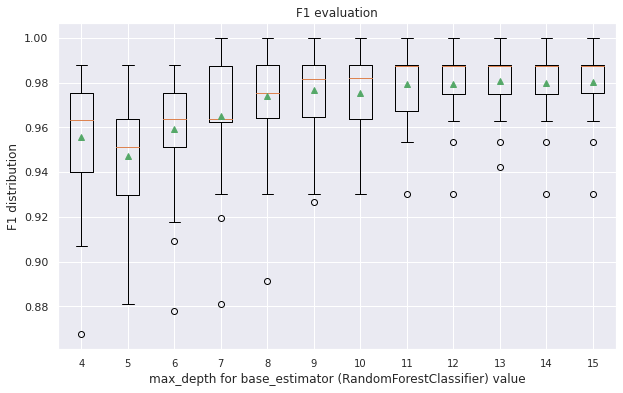

In [56]:
print('F1 evaluation (on "max_depth" of base_estimator model)')
models = get_models(range(4, 16), 
                    template = "AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth = value), random_state = RS)")
return_results(models, X, y, plot = True, par = 'max_depth for base_estimator (RandomForestClassifier)')

# Models Comparison

100%|██████████| 9/9 [08:00<00:00, 53.34s/it]


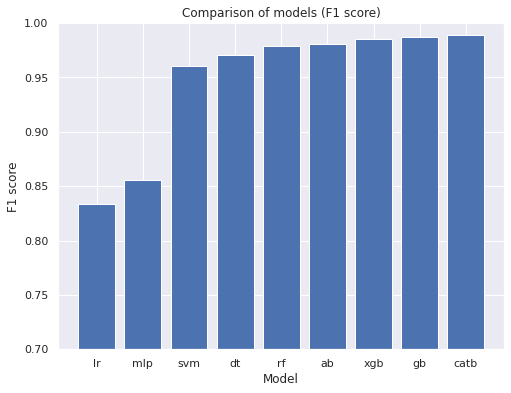

In [57]:
X_scaled = scaler.transform(X)

lr = LogisticRegression().set_params(**lr_bp)
svm = SVC().set_params(**svm_bp)
dtc = DecisionTreeClassifier().set_params(**dtc_bp)
mlp = MLPClassifier().set_params(**mlp_bp)
rf = RandomForestClassifier().set_params(**rfc_bp)
gb = GradientBoostingClassifier().set_params(**gb_bp)
catb = CatBoostClassifier().set_params(**cat_bp)
xgb = XGBClassifier().set_params(**xgb_bp)
ab = AdaBoostClassifier(base_estimator = RandomForestClassifier(max_depth = 13), random_state = RS)

models = [lr, svm, dtc, mlp, rf, gb, catb, xgb, ab]
need_scalling = [svm]
f1_scores, accs, recalls, precs = [], [], [], []
for model in tqdm(models):
  if model in need_scalling:
    X_data = X_scaled
  else:
    X_data = X.copy()
  f1_scores += [np.mean(cross_val_score(model, X_data, y, scoring = 'f1', cv = cv))]
  accs += [np.mean(cross_val_score(model, X_data, y, scoring = 'accuracy', cv = cv))]
  recalls += [np.mean(cross_val_score(model, X_data, y, scoring = 'recall', cv = cv))]
  precs += [np.mean(cross_val_score(model, X_data, y, scoring = 'precision', cv = cv))]

models = ['lr','svm','dt','mlp','rf', 'gb','catb','xgb', 'ab']
data_tuples = list(zip(models,f1_scores))
data_f1_scores = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'F1'}).set_index('Model')
data_tuples = list(zip(models, accs))
data_accs = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Accuracy'}).set_index('Model')
data_tuples = list(zip(models, recalls))
data_recalls = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Recall'}).set_index('Model')
data_tuples = list(zip(models, precs))
data_precs = pd.DataFrame(data_tuples).rename(columns = {0:'Model', 1:'Precision'}).set_index('Model')
data = pd.concat([data_f1_scores, data_accs, data_recalls, data_precs], axis = 1).sort_values('F1').reset_index()
plt.bar(data['Model'], data['F1'])
plt.ylim(0.7, 1)
plt.xlabel('Model') 
plt.ylabel('F1 score') 
plt.title("Comparison of models (F1 score)")
plt.show()

In [58]:
data

,Model,F1,Accuracy,Recall,Precision
0,lr,0.833707,0.826250,0.847522,0.823877
1,mlp,0.855733,0.848750,0.871874,0.843274
2,svm,0.960587,0.959583,0.958614,0.963536
3,dt,0.970472,0.970000,0.961092,0.980962
4,rf,0.978531,0.977917,0.978126,0.979343
5,ab,0.980721,0.980000,0.983779,0.978233
6,xgb,0.985083,0.984583,0.985424,0.985166
7,gb,0.987121,0.986667,0.990263,0.984440
8,catb,0.989466,0.989167,0.989450,0.989745


We compared all models we created.<br>
As we can see the best model is **Random Forest**.<br>
But let's check a Stacking Classifier based on the best models

## Stacking Classifier

In [59]:
print('(GB + RF) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp))]
            
st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.984196954483417,
 'Accuracy': 0.9837500000000001,
 'Recall': 0.9845722028648858,
 'Precision': 0.9843024666994723}

In [63]:
print('(GB + RF + SVM) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp)),
              ('svm', SVC(**svm_bp))]
            
st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF + SVM) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9878465404984286,
 'Accuracy': 0.9875,
 'Recall': 0.987824235385211,
 'Precision': 0.9882119235777772}

In [65]:
print('(GB + RF + SVM + AB) + RF')
estimators = [('gb', GradientBoostingClassifier().set_params(**gb_bp)),
              ('rf', RandomForestClassifier().set_params(**rfc_bp)),
              ('svm', SVC(**svm_bp)),
              ('ab', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth = 5), learning_rate = 1.5, random_state = RS))]

st = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state = RS))
print('\nAverage Metrics using K-Folds CV (obtained model):')
peformance_check(st, X)

(GB + RF + SVM + AB) + RF

Average Metrics using K-Folds CV (obtained model):


{'f1': 0.9886597691573193,
 'Accuracy': 0.9883333333333334,
 'Recall': 0.9886178861788618,
 'Precision': 0.989037764403618}

In [61]:
clf = GradientBoostingClassifier().set_params(**gb_bp).fit(X, y)
preds = clf.predict(test_df)

sub = pd.DataFrame(data = {'PatientID' : pid, 'Disease' : preds})
sub['Disease'] = sub['Disease'].astype(int)
sub

,PatientID,Disease
0,1343,1
1,1727,1
2,1828,1
3,1155,1
4,1020,0
...,...,...
220,1000,0
221,1256,1
222,1318,0
223,1953,1


## Final prediction

In [ ]:
# clf = RandomForestClassifier().fit(X, y)
# preds = clf.predict(test_df)

# sub = pd.DataFrame(data = {'PatientID' : pid, 'Disease' : preds})
# sub['Disease'] = sub['Disease'].astype(int)
# sub

In [62]:
sub.to_csv('Group18_VersionGB.csv', index = False)